<a href="https://colab.research.google.com/github/GrE3lzzz/Gittea/blob/main/My_Paypal_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    auc,
    roc_auc_score,
    average_precision_score,
    f1_score,
)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
import joblib
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
# Load the dataset
url = "https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv"
data = pd.read_csv(url)

In [ ]:
# Display basic information
print("Dataset Shape:", data.shape)
print("\nFirst 5 Rows:\n", data.head())
print("\nClass Distribution:\n", data["Class"].value_counts(normalize=True))

Dataset Shape: (284807, 31)

First 5 Rows:
    Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0

In [ ]:
# Normalize 'Time' and 'Amount' features
scaler = StandardScaler()
data["Time"] = scaler.fit_transform(data["Time"].values.reshape(-1, 1))
data["Amount"] = scaler.fit_transform(data["Amount"].values.reshape(-1, 1))

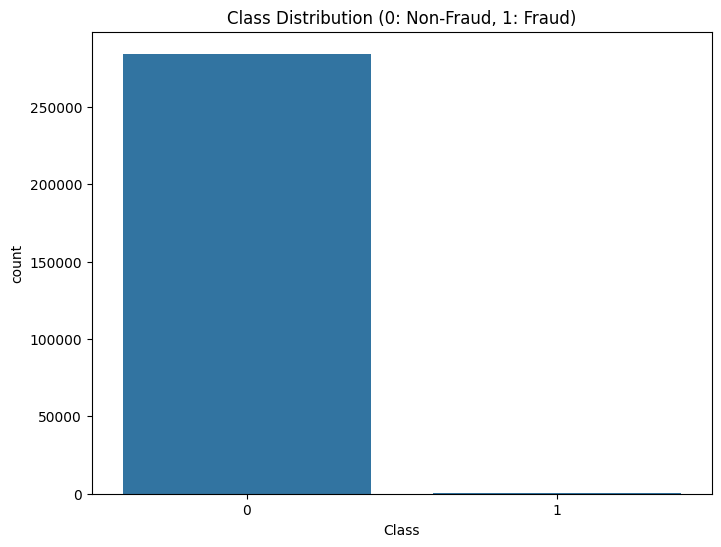

In [ ]:
# Data Exploration: Class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x="Class", data=data)
plt.title("Class Distribution (0: Non-Fraud, 1: Fraud)")
plt.show()

In [ ]:
# Split the data into features and target
X = data.drop("Class", axis=1)
y = data["Class"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Handle class imbalance using SMOTE and Random Under-Sampling
smote = SMOTE(random_state=42)
rus = RandomUnderSampler(random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

In [ ]:
# Function to evaluate the model
def evaluate_model(y_true, y_pred, y_proba, model_name):
    print(f"Evaluation for {model_name}:")
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred))

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    auprc = auc(recall, precision)
    print(f"Area Under Precision-Recall Curve (AUPRC): {auprc:.4f}")

    # ROC-AUC Score
    roc_auc = roc_auc_score(y_true, y_proba)
    print(f"ROC-AUC Score: {roc_auc:.4f}")

    # Plot confusion matrix
    plot_confusion_matrix(y_true, y_pred, model_name)

In [ ]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Non-Fraud", "Fraud"],
                yticklabels=["Non-Fraud", "Fraud"])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

Evaluation for Logistic Regression (SMOTE):
Confusion Matrix:
 [[55406  1458]
 [    8    90]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962

Area Under Precision-Recall Curve (AUPRC): 0.7703
ROC-AUC Score: 0.9698


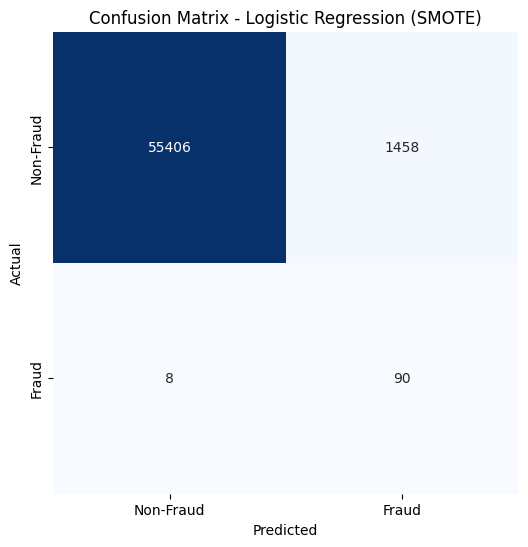

In [ ]:
# Logistic Regression (Baseline with SMOTE)
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_smote, y_train_smote)
y_pred_log_reg = log_reg.predict(X_test)
y_proba_log_reg = log_reg.predict_proba(X_test)[:, 1]
evaluate_model(y_test, y_pred_log_reg, y_proba_log_reg, "Logistic Regression (SMOTE)")

Evaluation for Random Forest (SMOTE):
Confusion Matrix:
 [[56849    15]
 [   16    82]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.85      0.84      0.84        98

    accuracy                           1.00     56962
   macro avg       0.92      0.92      0.92     56962
weighted avg       1.00      1.00      1.00     56962

Area Under Precision-Recall Curve (AUPRC): 0.8767
ROC-AUC Score: 0.9731


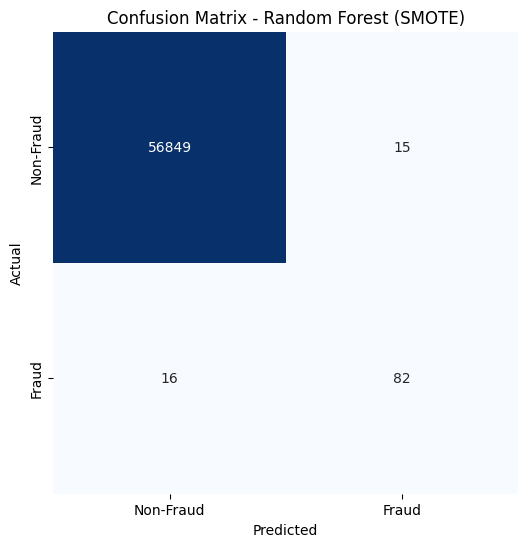

In [ ]:
# Random Forest (with SMOTE)
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_smote, y_train_smote)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]
evaluate_model(y_test, y_pred_rf, y_proba_rf, "Random Forest (SMOTE)")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 394, number of negative: 394
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000898 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7649
[LightGBM] [Info] Number of data points in the train set: 788, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluation for LightGBM (RUS):
Confusion Matrix:
 [[54426  2438]
 [    8    90]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98     56864
           1       0.04      0.92      0.07        98

    accuracy                           0.96     56962
   macro avg       0.52      0.94      0.52     56962
weighted avg       1.00      0.96      0.98     56962

Area Under Precision-Recall Curve (AUPRC): 0.6491
ROC-AUC Score: 0.9738


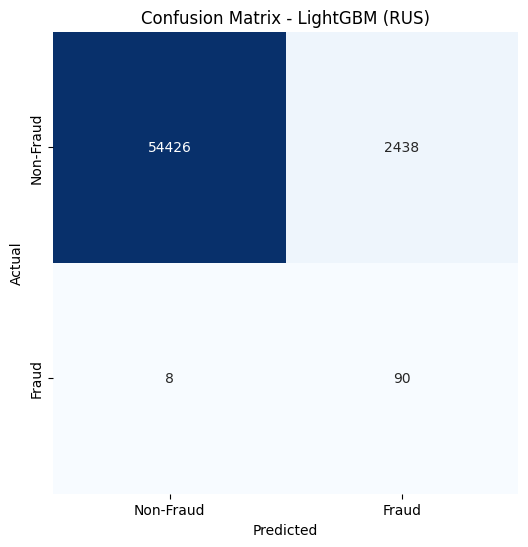

In [ ]:
# LightGBM (with Random Under-Sampling)
numeric_features = X.columns.tolist()
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())  # RobustScaler handles outliers better
])

preprocessor = ColumnTransformer(
    transformers=[('num', numeric_transformer, numeric_features)]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(random_state=42))
])

pipeline.fit(X_train_rus, y_train_rus)
y_pred_lgbm = pipeline.predict(X_test)
y_proba_lgbm = pipeline.predict_proba(X_test)[:, 1]
evaluate_model(y_test, y_pred_lgbm, y_proba_lgbm, "LightGBM (RUS)")

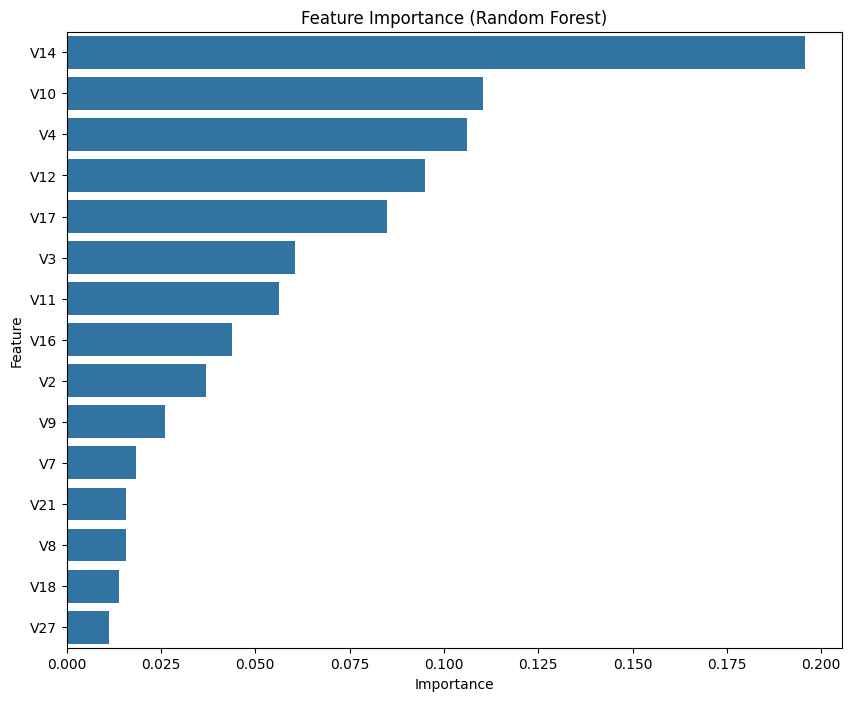

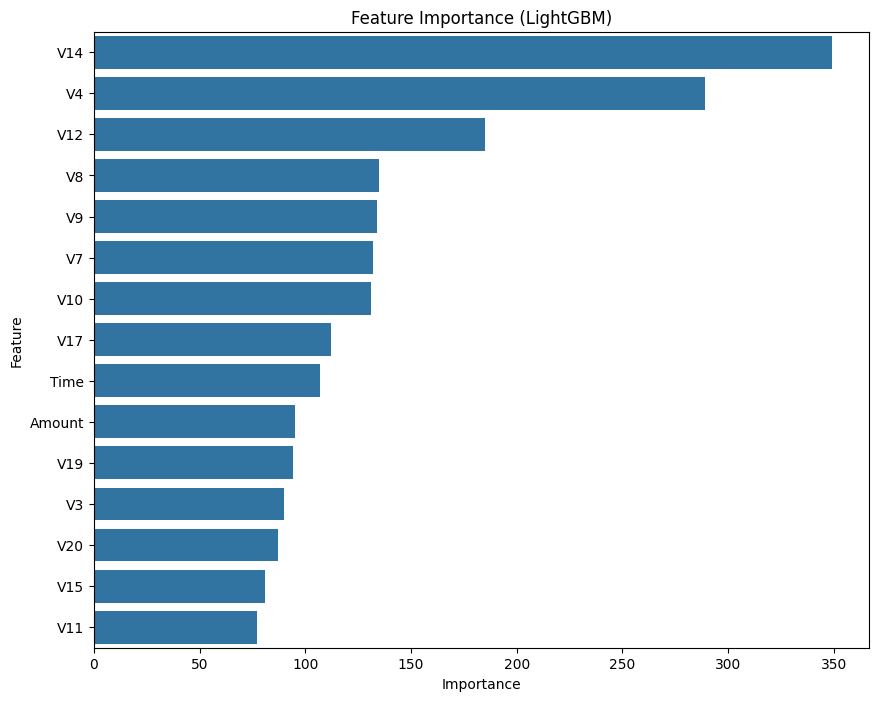

In [ ]:
# Feature Importance (Random Forest and LightGBM)
feature_importance_rf = rf.feature_importances_
feature_importance_lgbm = pipeline.named_steps['classifier'].feature_importances_
feature_names = X.columns

# Random Forest Feature Importance
importance_df_rf = pd.DataFrame({"Feature": feature_names, "Importance": feature_importance_rf})
importance_df_rf = importance_df_rf.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x="Importance", y="Feature", data=importance_df_rf[:15])  # Top 15 features
plt.title("Feature Importance (Random Forest)")
plt.show()

# LightGBM Feature Importance
importance_df_lgbm = pd.DataFrame({"Feature": feature_names, "Importance": feature_importance_lgbm})
importance_df_lgbm = importance_df_lgbm.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x="Importance", y="Feature", data=importance_df_lgbm[:15])  # Top 15 features
plt.title("Feature Importance (LightGBM)")
plt.show()

In [ ]:
# Hyperparameter Tuning for LightGBM
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__max_depth': [3, 5]
}

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='f1', cv=3, n_jobs=-1)
grid_search.fit(X_train_rus, y_train_rus)

print("\nBest Parameters for LightGBM:", grid_search.best_params_)
best_pipeline = grid_search.best_estimator_

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 394, number of negative: 394
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7649
[LightGBM] [Info] Number of data points in the train set: 788, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluation for Best LightGBM (RUS):
Confusion Matrix:
 [[53972  2892]
 [    7    91]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97     56864
           1       0.03      0.93      0.06        98

    accuracy                           0.95     56962
   macro avg       0.52      0.94      0.52     56962
weighted avg       1.00      0.95      0.97     56962

Area Under Precision-Recall Curve (AUPRC): 0.6841
ROC-AUC Score: 0.9688


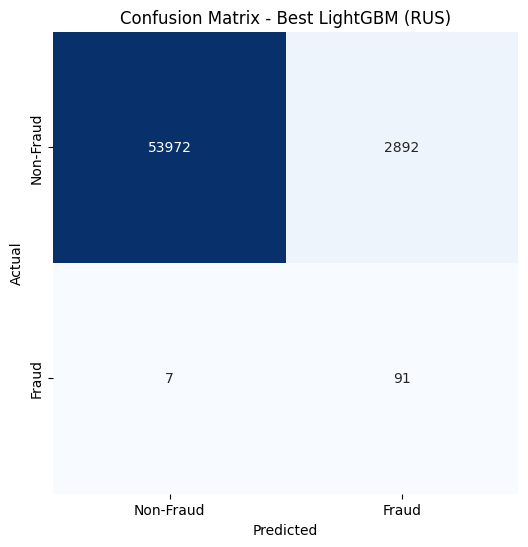


Model saved successfully.


In [ ]:
# Evaluate the best LightGBM model
y_pred_best_lgbm = best_pipeline.predict(X_test)
y_proba_best_lgbm = best_pipeline.predict_proba(X_test)[:, 1]
evaluate_model(y_test, y_pred_best_lgbm, y_proba_best_lgbm, "Best LightGBM (RUS)")

# Save the Best Model
joblib.dump(best_pipeline, 'fraud_detection_lightgbm_model.pkl')
print("\nModel saved successfully.")

In [ ]:
# Simulate Business Impact
def simulate_business_impact(y_true, y_pred, cost_per_false_positive, cost_per_false_negative):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    total_cost = (fp * cost_per_false_positive) + (fn * cost_per_false_negative)
    revenue_saved = (tp * cost_per_false_negative)  # Revenue from detecting fraud

    print(f"Total Cost of Errors: ${total_cost}")
    print(f"Revenue Saved by Detecting Fraud: ${revenue_saved}")
    print(f"Net Impact: ${revenue_saved - total_cost}")

# Example costs (hypothetical values)
cost_per_false_positive = 10  # Cost of blocking a genuine transaction
cost_per_false_negative = 100  # Cost of missing a fraudulent transaction

simulate_business_impact(y_test, y_pred_best_lgbm, cost_per_false_positive, cost_per_false_negative)

Total Cost of Errors: $29620
Revenue Saved by Detecting Fraud: $9100
Net Impact: $-20520


In [ ]:
# Threshold Optimization for Best Model
def optimize_threshold(y_true, y_proba, thresholds):
    results = []
    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        precision, recall, f1 = precision_score(y_true, y_pred), recall_score(y_true, y_pred), f1_score(y_true, y_pred)
        results.append((threshold, precision, recall, f1))
    return pd.DataFrame(results, columns=["Threshold", "Precision", "Recall", "F1"])

thresholds = np.linspace(0.1, 0.9, 50)
threshold_results = optimize_threshold(y_test, y_proba_best_lgbm, thresholds)

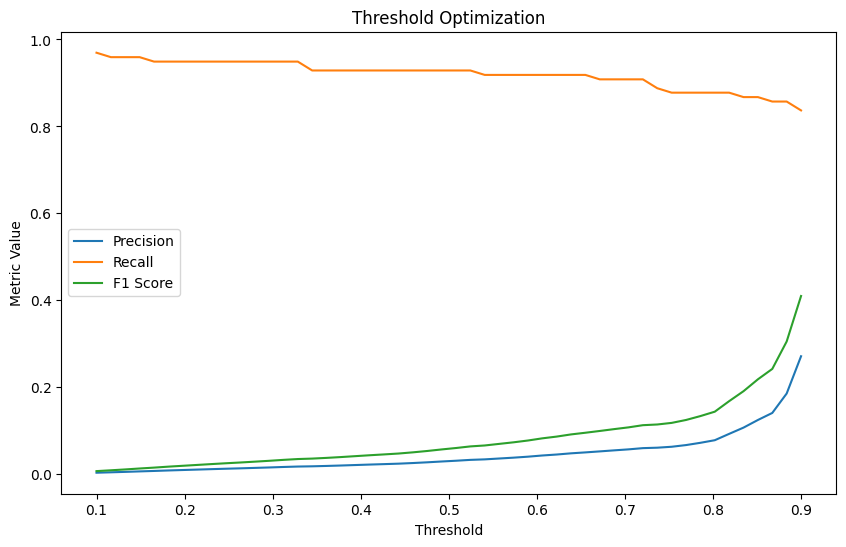

In [ ]:
# Plot threshold optimization results
plt.figure(figsize=(10, 6))
plt.plot(threshold_results["Threshold"], threshold_results["Precision"], label="Precision")
plt.plot(threshold_results["Threshold"], threshold_results["Recall"], label="Recall")
plt.plot(threshold_results["Threshold"], threshold_results["F1"], label="F1 Score")
plt.title("Threshold Optimization")
plt.xlabel("Threshold")
plt.ylabel("Metric Value")
plt.legend()
plt.show()

Optimal Threshold: 0.90
Evaluation for Best LightGBM (Optimized Threshold):
Confusion Matrix:
 [[56644   220]
 [   16    82]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.27      0.84      0.41        98

    accuracy                           1.00     56962
   macro avg       0.64      0.92      0.70     56962
weighted avg       1.00      1.00      1.00     56962

Area Under Precision-Recall Curve (AUPRC): 0.6841
ROC-AUC Score: 0.9688


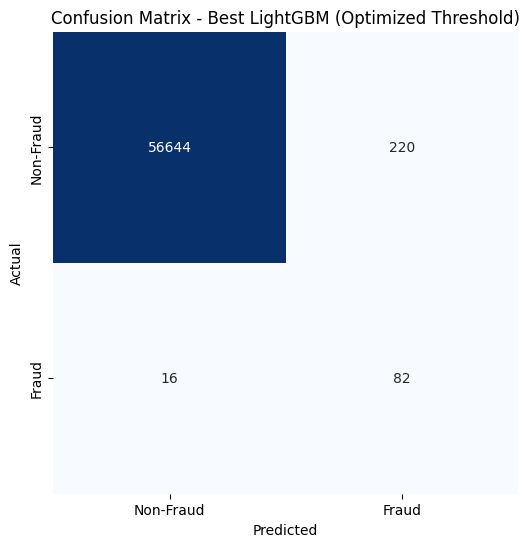

In [ ]:
# Select optimal threshold based on F1 score
optimal_threshold = threshold_results.loc[threshold_results["F1"].idxmax(), "Threshold"]
print(f"Optimal Threshold: {optimal_threshold:.2f}")

# Re-evaluate model with optimal threshold
y_pred_optimal = (y_proba_best_lgbm >= optimal_threshold).astype(int)
evaluate_model(y_test, y_pred_optimal, y_proba_best_lgbm, "Best LightGBM (Optimized Threshold)")